In [1]:
# Import modules here
import uproot
import pandas
import numpy as np
import collections
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from matplotlib.lines import Line2D

# Specify parameters here
inDir = '/Users/avalee/athenaOutputs/'
outDir = '/Users/avalee/Downloads/JFPlots/'
version = '427080_Zprime_V5'
tracks = ['nominal', 'ideal', 'HF']
#file = uproot.open(inDir + version + "_" + tracks[0] + "_all_flav_Akt4EMTo.root")

if not (os.path.isdir(outDir)): os.makedirs(outDir)

In [10]:
def getVarsDataframe(file, allVars):
    tree = file['bTag_AntiKt4EMTopoJets']
    baselineVars = ['jet_pt', 'jet_eta', 'jet_LabDr_HadF', 'jet_dRiso']
    df = pandas.DataFrame(columns=baselineVars, data=tree.arrays(baselineVars, flatten=True, namedecode="utf-8"))
    df['jet_pt'] = df['jet_pt'].div(1000)
    selected = df[(df['jet_pt']>100) & (df['jet_pt']<5000) & (abs(df['jet_eta'])<2.1) & (df['jet_dRiso']>1.0) & (df['jet_LabDr_HadF']!=15)]
    var_df = pandas.DataFrame(columns=allVars, data=tree.arrays(allVars, flatten=True, namedecode="utf-8"))
    var_df = var_df.loc[selected.index, :]
    return var_df

# 499968 events and each event can have more than one jet
# 2464473 jets
# all jet variables contain info corresponding to each jet
def getHitsDataframe(file, allVars):
    tree = file['bTag_AntiKt4EMTopoJets']
    baselineVars = ['jet_pt', 'jet_eta', 'jet_LabDr_HadF', 'jet_dRiso']
    df = pandas.DataFrame(columns=baselineVars, data=tree.arrays(baselineVars, flatten=True, namedecode="utf-8"))
    df['jet_pt'] = df['jet_pt'].div(1000)
    selected = df[(df['jet_pt']>100) & (df['jet_pt']<5000) & (abs(df['jet_eta'])<2.1) & (df['jet_dRiso']>1.0) & (df['jet_LabDr_HadF']!=15)]
    
    allHits = {}
    for varName in allVars:
        if varName == 'jet_trk_nPixSCT':
            continue
        if varName == 'jet_trk_nsharedPixSCT':
            continue
        hits = tree[varName].array()
        selectedHits = []
        count = -1
        counts = []
        for i in range(len(hits)):
            for j in range(len(hits[i])):
                count += 1
                if count in selected.index:
                    counts.append(count)
                    selectedHits.append(hits[i][j])
        allHits[varName] = np.concatenate((selectedHits))
    
    hits_df = pandas.DataFrame.from_dict(allHits)
    return hits_df

def tracksDataFrames(tracks, allVars):
    dataFramesDict = collections.OrderedDict()
    for i in range(len(tracks)):
        label = tracks[i]
        file = uproot.open(inDir + version + "_" + tracks[i] + "_all_flav_Akt4EMTo.root")
        if label=="nominal":
            allVars.append('jet_trk_truthMatchProbability')
        print (allVars)
        dataFramesDict[label] = getHitsDataframe(file, allVars)
    return dataFramesDict

def getRatio(hist1,hist2):
    hist = []
    for i in range(len(hist1)):
        if hist2[i] == 0:
            if hist1[i] == 0: value = 1
            else: value = 0
        else: value = hist1[i]/hist2[i]
        hist.append(value)
    return hist

In [12]:
varHitsDict = {
        'jet_trk_nPixSCT': [0, 14, 14, 'Number of pixel and SCT hits'],
        'jet_trk_nsharedPixSCT': [0, 10, 10, 'Number of shared pixels and SCT hits'],
        'jet_trk_nPixHits': [0, 10, 10, 'Number of pixel hits'],
        'jet_trk_nSCTHits': [0, 14, 14, 'Number of SCT hits'],
        'jet_trk_nsharedPixHits': [0, 10, 10, "Number of shared pixels"],
        'jet_trk_nsharedSCTHits': [0, 10, 10, "Number of shared SCT"],
        'jet_trk_nsplitPixHits': [0, 10, 10, "Number of split pixels"],     
    
}

colourDict = {
		'nominal': "#000000",
		'pseudo': "#17becf",
		'ideal': "#ff7f0e",
		'fakes_removed': "#2ca02c",
		'fakes_removed_+_track_replaced': "#d62728",
		'HF': "#9467bd",
		'HF_+_track_replaced': "#e377c2",
        'fake': "#bcbd22"
	}

yLabel = 'Arbitrary units'

allVars = list(varHitsDict.keys())
print (type(allVars))
dataFrames = tracksDataFrames(tracks, allVars)

<class 'list'>
['jet_trk_nPixSCT', 'jet_trk_nsharedPixSCT', 'jet_trk_nPixHits', 'jet_trk_nSCTHits', 'jet_trk_nsharedPixHits', 'jet_trk_nsharedSCTHits', 'jet_trk_nsplitPixHits', 'jet_trk_truthMatchProbability']
['jet_trk_nPixSCT', 'jet_trk_nsharedPixSCT', 'jet_trk_nPixHits', 'jet_trk_nSCTHits', 'jet_trk_nsharedPixHits', 'jet_trk_nsharedSCTHits', 'jet_trk_nsplitPixHits', 'jet_trk_truthMatchProbability']
['jet_trk_nPixSCT', 'jet_trk_nsharedPixSCT', 'jet_trk_nPixHits', 'jet_trk_nSCTHits', 'jet_trk_nsharedPixHits', 'jet_trk_nsharedSCTHits', 'jet_trk_nsplitPixHits', 'jet_trk_truthMatchProbability']


In [ ]:
nom_df = dataFrames["nominal"]
fake_df = nom_df[(nom_df['jet_trk_truthMatchProbability']<0.75)]
dataFrames["fake"] = fake_df

In [98]:
def getArray(track, dataFrames, varName):
    df_track = dataFrames[track]
    if varName == 'jet_trk_nPixSCT':
        nPix = df_track['jet_trk_nPixHits']
        nSCT = df_track['jet_trk_nSCTHits']
        array = nPix + nSCT
    elif varName == 'jet_trk_nsharedPixSCT':
        nPix = df_track['jet_trk_nsharedPixHits']
        nSCT = df_track['jet_trk_nsharedSCTHits']
        array = nPix + nSCT
    else: array = df_track[varName]
    
    return array

def fetchArrays(dataFrames, varName):
    arraysDict = collections.OrderedDict()
    for track in dataFrames.keys():
        tmpArray = getArray(track, dataFrames, varName)
        #if tracks[i] =="fakes_removed":
            #nomArray = getArray("nominal", dataFrames, varName)
            #fakeArray = nomArray - tmpArray
            #tmpArray = fakeArray
            #label = "fake"
        tmpArray = tmpArray[~np.isnan(tmpArray)]
        arraysDict[track] = tmpArray
    return arraysDict

def plotHistos(dataFrames, varName, xMin, xMax, xBins, varLabel, yLabel):
    figName = varName
    # Fetch histograms
    histoDict = fetchArrays(dataFrames, varName)
    # Styling
    plt.rcParams["font.family"] = "Arial"
    my_dpi = 100
    
    fig = plt.figure(figsize=(550/my_dpi, 450/my_dpi), dpi=my_dpi)
    gs = gridspec.GridSpec(2,1 , height_ratios=[4,1])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    fig.subplots_adjust(hspace=0.05)
    
    # Settings for x and y-axis
    ax1.xaxis.set_visible(False)
    ax1.set_ylabel(yLabel)
    ax1.set_xlim([xMin, xMax])
    
    ax2.set_ylabel("Ratio")
    ax2.set_xlabel(varLabel)
    ax2.set_xlim([xMin, xMax])
    ax2.set_xticks(range(xMin,xMax))
    if 'n' in varName:
        ax2.set_xticks(np.arange(xMin+0.5,xMax+0.5,1), minor=True)
        ax2.set_xticklabels(np.arange(xMin,xMax), minor=True)
        ax2.set_xticklabels([])
        ax2.set_xticks([])
    
    # Plot histograms
    yMaxs = []
    for histKey in histoDict.keys():
        if histKey == "fakes_removed": continue
        if '_+_' in histKey: histKey = histKey.replace('_+_', ',_')
        y, x, _ = ax1.hist(histoDict[histKey], bins=xBins, range=(xMin,xMax), density=True, color=colourDict[histKey], histtype='step', label=histKey)
        yMaxs.append(y.max())
        # Get ratios
        histNom, bin_edges = np.histogram(histoDict["nominal"], bins=xBins, range=(xMin,xMax), density=True)
        hist, bin_edges = np.histogram(histoDict[histKey], bins=xBins, range=(xMin,xMax), density=True)
        ratio = getRatio(hist, histNom)
        
        # Plot ratios
        left,right = bin_edges[:-1],bin_edges[1:]
        X = np.array([left,right]).T.flatten()
        Y = np.array([ratio,ratio]).T.flatten()
        ax2.plot(X,Y, color=colourDict[histKey], linewidth=1)
        
    ax1.set_ylim([0, max(yMaxs)*1.35])
    # Draw a line for legend
    handles, labels = ax1.get_legend_handles_labels()
    new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
    ax1.legend(handles=new_handles, labels=labels, labelspacing=0.3, facecolor='none', edgecolor='none', loc='best', bbox_to_anchor=(0.4, 0.5, 0.5, 0.5))
    
    plt.savefig(outDir + varName +".png", bbox_inches='tight', pad_inches=0.)
    plt.savefig(outDir + varName+".pdf", bbox_inches='tight', pad_inches=0.)

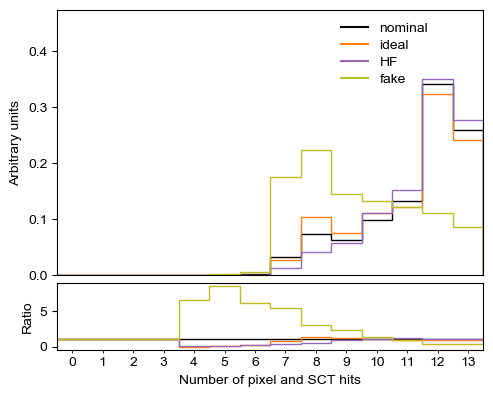

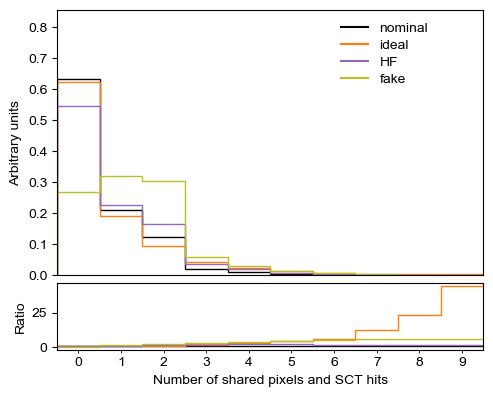

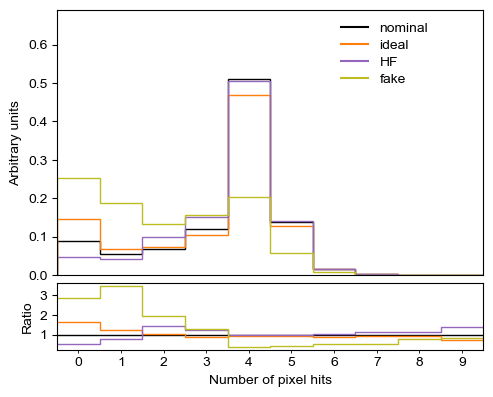

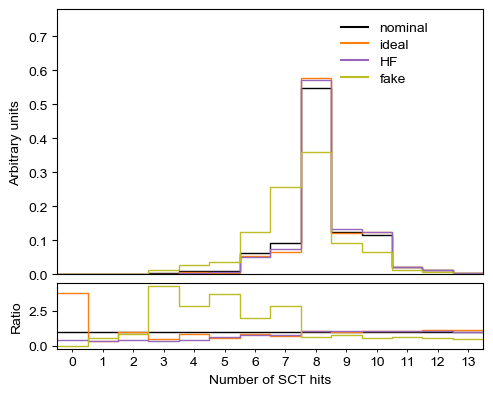

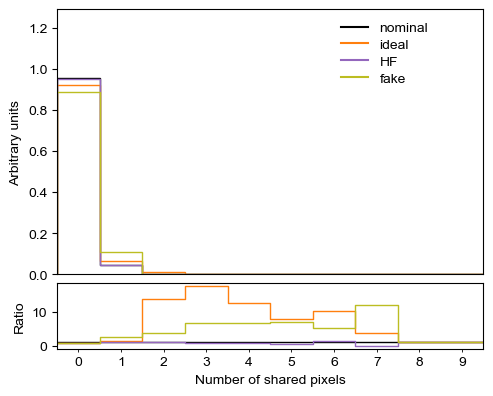

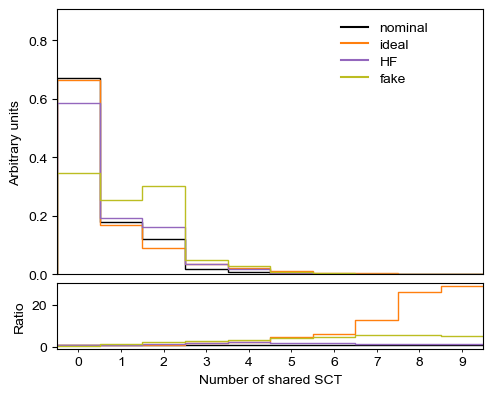

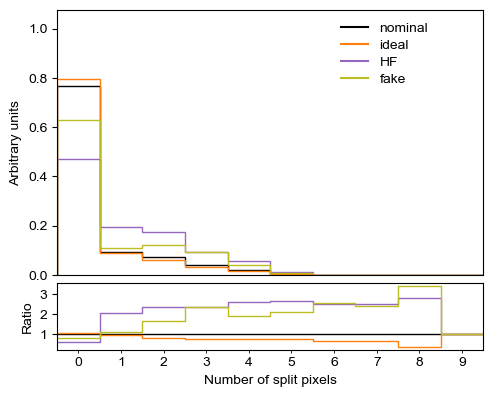

In [99]:
for varName, varValues in varHitsDict.items():
    xMin = varValues[0]
    xMax = varValues[1]
    xBins = varValues[2]
    varLabel = varValues[3]
    
    plotHistos(dataFrames, varName, xMin, xMax, xBins, varLabel, yLabel)